# COMPAS - Algoritmerevisjon

### a) - Oversikt over data

C:\Users\leand\AppData\Local\Temp\ipykernel_23684\1407254792.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["is_recid"] = df_new["is_recid"].map(str)


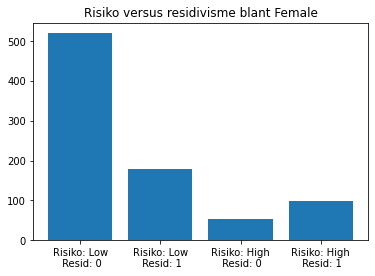

9.25 % av Female som ikke residiverte ble kategorisert som høyrisiko
35.38 % av Female som residiverte ble kategorisert som høyrisiko


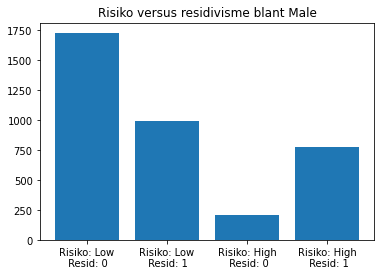

11.02 % av Male som ikke residiverte ble kategorisert som høyrisiko
43.94 % av Male som residiverte ble kategorisert som høyrisiko


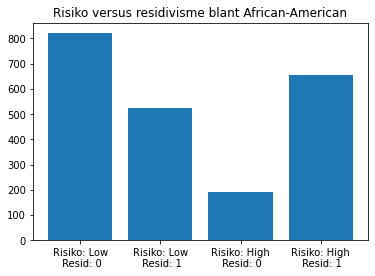

18.79 % av African-American som ikke residiverte ble kategorisert som høyrisiko
55.51 % av African-American som residiverte ble kategorisert som høyrisiko


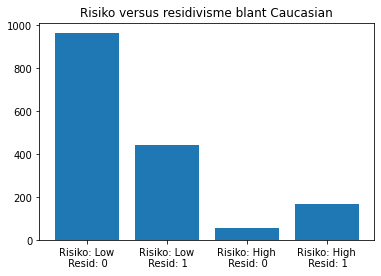

5.5 % av Caucasian som ikke residiverte ble kategorisert som høyrisiko
27.33 % av Caucasian som residiverte ble kategorisert som høyrisiko


In [40]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data.csv", delimiter=",")
df = df.dropna(subset=["age"])
df = df[df["days_b_screening_arrest"] <= 30]
df = df[df["days_b_screening_arrest"] >= -30]


for pair in [["sex", "Female"], ["sex", "Male"], ["race", "African-American"], ["race", "Caucasian"]]:
    df_new = df[df[pair[0]].str.contains(pair[1])]
    df_new["is_recid"] = df_new["is_recid"].map(str)

    cat = []
    risk_recid = []
    for i in ["Low", "High"]:
        for j in (0,1):
            A1 = df_new[df_new["score_text"].str.contains(i)]
            A2 = A1[A1["is_recid"].str.contains(f"{j}")]
            risk_recid.append(f"Risiko: {i}\n Resid: {j}")
            cat.append(len(A2))

    plt.bar(risk_recid, cat)
    plt.title(f"Risiko versus residivisme blant {pair[1]}")
    plt.show()
    
    print(f"{round(cat[2]/(cat[0] + cat[2])*100, 2)} % av {pair[1]} som ikke residiverte ble kategorisert som høyrisiko")
    print(f"{round(cat[3]/(cat[1] + cat[3])*100, 2)} % av {pair[1]} som residiverte ble kategorisert som høyrisiko")

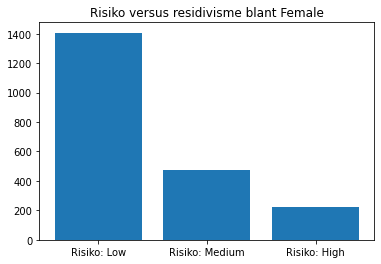

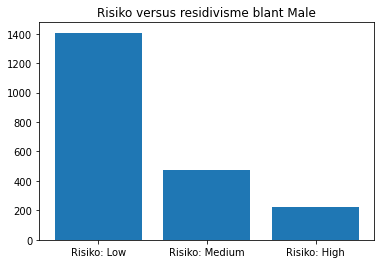

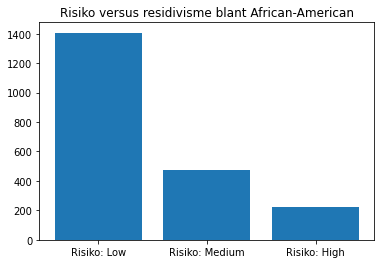

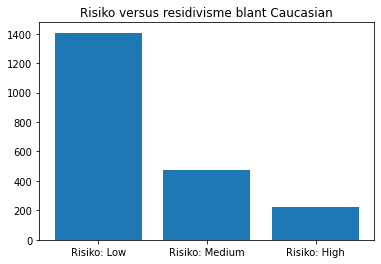

In [42]:
for pair in [["sex", "Female"], ["sex", "Male"], ["race", "African-American"], ["race", "Caucasian"]]:
    df_rec = df[df[pair[0]].str.contains(pair[1])]

    cat = []
    risk_recid = []
    for i in ["Low", "Medium", "High"]:
        for j in (0,1):
            A1 = df_new[df_new["score_text"].str.contains(i)]
            risk_recid.append(f"Risiko: {i}")
            cat.append(len(A1))

    plt.bar(risk_recid, cat)
    plt.title(f"Risiko versus residivisme blant {pair[1]}")
    plt.show()

In [5]:


categorical_columns = ["sex", "age_cat", "race"]

for i in categorical_columns:
    dfoh = pd.get_dummies(df[i], prefix=i)
    df = df.drop(i, axis = 1)
    df = df.join(dfoh)


X = df[["sex_Male", "sex_Female", "age_cat_Less than 25", "age_cat_25 - 45", "age_cat_Greater than 45", "race_Other", "race_African-American", "race_Caucasian", "race_Hispanic", "juv_fel_count", "juv_misd_count", "priors_count"]]
Y = df["decile_score"]
    